# CS6120 NLP Fall 2023 Assignment 3

## Implementing Skipgram and CBOW Algorithms

### Background: 
Word embeddings are dense vector representations of words in a continuous vector space. Skipgram and CBOW are two primary algorithms introduced by Mikolov et al. in their 2013 papers that form the basis of the popular word2vec model. While both are used for generating word embeddings, they use different architectures and techniques.

- Skipgram: Given a word, this model predicts the surrounding context words.
- CBOW (Continuous Bag-of-Words): Given context words, this model predicts the target word.

### Tasks:
1. Data Collection:
Download the text8 dataset, which is a cleaned version of the first 100MB of the English Wikipedia dump. It is available on several NLP data repositories.



In [2]:
import requests

# Download the dataset
url = "http://mattmahoney.net/dc/text8.zip"
response = requests.get(url, allow_redirects = True)

with open('text8.zip', 'wb') as f:
    f.write(response.content)

In [3]:
# Loading and preparing the text8 dataset
with open('text8', 'r') as file:
    data = file.read()
    
print(data[:1000])
print(type(data))
print('The length of the {} is {}' .format('`data`', len(data)))

 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in place of what are regarded as authoritarian political structures and coercive economic instituti

2. Pre-processing:
- Tokenize the dataset.
- Remove stopwords and non-alphabetic tokens.
- Build a vocabulary of the most frequent words (e.g., top 10,000 or 20,000 words).

In [239]:
# import package
import numpy as np
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import pandas as pd
import re
import numpy as np
from nltk.tokenize import  word_tokenize
import nltk
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
# add more packages
from typing import Dict
from typing import Set
from typing import List
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score
from collections import defaultdict
from nltk.corpus import stopwords
import string
import numpy as np
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import random
from math import sqrt
from itertools import chain
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [5]:
# Clean data
def clean_corpus(line: list[str]) -> list[str]:
    '''
    preprocess and clean a given line.

    - line: The text line to be cleaned.
    ---
    - list: A list of preprocessed tokens from the line.
    '''
    tokens = word_tokenize(line)
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]  
    return tokens


In [38]:
# Preprocessing the data
lines: list[list[str]] = []

# Predefined list of stop words
stop_words: set = set(stopwords.words('english'))

# Tokenize the text documents and update the lists word_list and lines
lines = clean_corpus(data)
print(len(lines))
lines[:10]

10888361


['anarchism',
 'originated',
 'term',
 'abuse',
 'first',
 'used',
 'early',
 'working',
 'class',
 'radicals']

In [242]:
# Build a vocabulary of the most frequent words (e.g., top 10,000 or 20,000 words).
word_counts = Counter(lines)
top_freq_words = [word for word, count in word_counts.most_common(10000)]
top_freq_words[:50]


['one',
 'zero',
 'nine',
 'two',
 'eight',
 'five',
 'three',
 'four',
 'six',
 'seven',
 'also',
 'first',
 'many',
 'new',
 'used',
 'american',
 'time',
 'see',
 'may',
 'world',
 'b',
 'would',
 'however',
 'years',
 'states',
 'people',
 'war',
 'united',
 'known',
 'called',
 'use',
 'th',
 'system',
 'often',
 'state',
 'history',
 'city',
 'english',
 'made',
 'well',
 'e',
 'number',
 'government',
 'later',
 'since',
 'part',
 'name',
 'c',
 'century',
 'x']

### Subsampling data

In [79]:
# Subsampling

# Flatten the nested list
flattened_lines = lines

t = 1e-5 # # Hyperparameters

word_counts = Counter(flattened_lines)
total_count = len(flattened_lines)
frequencies = {word: count/total_count for word, count in word_counts.items()}


def subsample_prob(word):
    prob = max(0, 1 - sqrt(t / frequencies[word]))
    return prob

subsamped_lines = [word for word in flattened_lines if random.random() > subsample_prob(word)]

In [80]:
print(len(subsamped_lines))

4129394


In [81]:
# Check subsample
subsamped_lines[:10]

['anarchism',
 'originated',
 'working',
 'radicals',
 'diggers',
 'sans',
 'culottes',
 'used',
 'pejorative',
 'organization']

3. Implement CBOW:
- Create the architecture for CBOW with an embedding layer and a linear layer.
- Generate training samples. For each word in the dataset, use n surrounding words as context.
- Train the model using a suitable optimizer and loss function.
- Extract word embeddings for the vocabulary.

CBOW is Continuous Bag Of Words, another vision of Word2Vec
- Reference: https://www.youtube.com/watch?v=ghu_5o42QGQ

In [215]:
# Generate training samples. For each word in the dataset, use n surrounding words as context.
def generate_context_pairs(corpus, window_size, vocab_set):
    data = []

    for i, word in enumerate(corpus):
        if word not in vocab_set:
            continue

        # Initialize an empty context list for the current word
        context = []

        # Define the start and end indices for the context words
        start_index = max(0, i - window_size)
        end_index = min(len(corpus), i + window_size + 1)

        # Loop over the surrounding words within the window
        for j in range(start_index, end_index):
            # Exclude the current word itself
            if j != i and corpus[j] in vocab_set:
                context.append(corpus[j])

        target = word
        data.append((context, target))

    return data



In [216]:
# check function of genreate
context_pairs = generate_context_pairs(subsamped_lines[:30000], 2, top_freq_words)

# print head 10
for i, (context, target) in enumerate(context_pairs[:10]):
    print(f"Pair {i+1}:")
    print("Context:", context)
    print("Target:", target)
    print("----------------------")

Pair 1:
Context: ['originated', 'working']
Target: anarchism
----------------------
Pair 2:
Context: ['anarchism', 'working']
Target: originated
----------------------
Pair 3:
Context: ['anarchism', 'originated']
Target: working
----------------------
Pair 4:
Context: ['organization']
Target: used
----------------------
Pair 5:
Context: ['used', 'positive', 'label']
Target: organization
----------------------
Pair 6:
Context: ['organization', 'label', 'anarchists']
Target: positive
----------------------
Pair 7:
Context: ['organization', 'positive', 'anarchists', 'anarchism']
Target: label
----------------------
Pair 8:
Context: ['positive', 'label', 'anarchism']
Target: anarchists
----------------------
Pair 9:
Context: ['label', 'anarchists', 'chief']
Target: anarchism
----------------------
Pair 10:
Context: ['anarchism', 'anarchism', 'belief']
Target: chief
----------------------


In [217]:
# Create the architecture for CBOW with an embedding layer and a linear layer.
class CBOW(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.linear = nn.Linear(embed_dim, vocab_size)

    def forward(self, context_words):
        embedded_words = self.embeddings(context_words)
        avg_embedded = embedded_words.mean(dim=1)  # Corrected dim to 1
        logits = self.linear(avg_embedded)
        return logits

In [218]:
# Dataset for DataLoader
class CBOWDataset(Dataset):
    def __init__(self, data, word2idx, max_context_size):
        self.data = data
        self.word2idx = word2idx
        self.max_context_size = max_context_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        context, target = self.data[idx]

        # Use <NEU> to paaend the context
        while len(context) < self.max_context_size:
            context.append("<NEU>")  # Use a special padding token. 

        context_indices = [self.word2idx[word] for word in context]
        target_index = self.word2idx[target]

        return torch.tensor(context_indices, dtype=torch.long), torch.tensor(target_index, dtype=torch.long)

In [219]:
# Hyperparameters
embedding_dim = 100
learning_rate = 0.01
epochs = 50
window_size = 2
BATCH_SIZE = 512

# Preparing data
vocab = set(top_freq_words)
vocab.add("<NEU>")
word2idx = {word: i for i, word in enumerate(vocab)}
idx2word = {i: word for word, i in word2idx.items()}

# Preprocess data
training_data = generate_context_pairs(subsamped_lines, window_size, vocab)
max_context_size = max([len(context) for context, _ in training_data])

train_dataset = CBOWDataset(training_data, word2idx, max_context_size)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model, Optimizer, Loss Function
model = CBOW(len(vocab), embedding_dim).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

# List to store losses
epoch_losses_cbow = []

In [220]:
# check GPU is work
# Train the model using a suitable optimizer and loss function.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.is_available())

cuda
True


In [221]:
# Training loop
for epoch in range(epochs):
    total_loss = 0
    batch_count = 0
    
    for context_tensors, target_tensors in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        
        context_tensors = context_tensors.to(device)
        target_tensors = target_tensors.to(device)

        optimizer.zero_grad()
        outputs = model(context_tensors)
        loss = loss_fn(outputs, target_tensors)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        batch_count += 1
    
    avg_loss = total_loss / batch_count
    epoch_losses_cbow.append(avg_loss)
    # This should give you a clearer view of the average loss per epoch.
    print(f"Epoch {epoch+1}, Avg Loss: {avg_loss}")   


Epoch 1: 100%|██████████| 4715/4715 [00:45<00:00, 104.18it/s]


Epoch 1, Avg Loss: 9.245584281201328


Epoch 2: 100%|██████████| 4715/4715 [00:45<00:00, 104.70it/s]


Epoch 2, Avg Loss: 9.20296287900696


Epoch 3: 100%|██████████| 4715/4715 [00:47<00:00, 98.42it/s] 


Epoch 3, Avg Loss: 9.177592237074075


Epoch 4: 100%|██████████| 4715/4715 [00:44<00:00, 105.57it/s]


Epoch 4, Avg Loss: 9.159443781459318


Epoch 5: 100%|██████████| 4715/4715 [00:44<00:00, 105.13it/s]


Epoch 5, Avg Loss: 9.145562298755504


Epoch 6: 100%|██████████| 4715/4715 [00:44<00:00, 105.50it/s]


Epoch 6, Avg Loss: 9.134780613969012


Epoch 7: 100%|██████████| 4715/4715 [00:44<00:00, 106.11it/s]


Epoch 7, Avg Loss: 9.126298185573024


Epoch 8: 100%|██████████| 4715/4715 [00:50<00:00, 93.35it/s] 


Epoch 8, Avg Loss: 9.119512933587473


Epoch 9: 100%|██████████| 4715/4715 [00:51<00:00, 90.75it/s] 


Epoch 9, Avg Loss: 9.114000343290392


Epoch 10: 100%|██████████| 4715/4715 [00:47<00:00, 98.92it/s] 


Epoch 10, Avg Loss: 9.10941593942814


Epoch 11: 100%|██████████| 4715/4715 [00:45<00:00, 102.57it/s]


Epoch 11, Avg Loss: 9.105540124482593


Epoch 12: 100%|██████████| 4715/4715 [00:47<00:00, 98.58it/s] 


Epoch 12, Avg Loss: 9.102201420934684


Epoch 13: 100%|██████████| 4715/4715 [00:44<00:00, 105.28it/s]


Epoch 13, Avg Loss: 9.099268881109081


Epoch 14: 100%|██████████| 4715/4715 [00:45<00:00, 104.64it/s]


Epoch 14, Avg Loss: 9.09665868077526


Epoch 15: 100%|██████████| 4715/4715 [00:44<00:00, 104.83it/s]


Epoch 15, Avg Loss: 9.094296564403546


Epoch 16: 100%|██████████| 4715/4715 [00:45<00:00, 104.39it/s]


Epoch 16, Avg Loss: 9.092117753539586


Epoch 17: 100%|██████████| 4715/4715 [00:44<00:00, 104.88it/s]


Epoch 17, Avg Loss: 9.090082469952321


Epoch 18: 100%|██████████| 4715/4715 [00:48<00:00, 97.71it/s] 


Epoch 18, Avg Loss: 9.088195722302855


Epoch 19: 100%|██████████| 4715/4715 [00:44<00:00, 104.83it/s]


Epoch 19, Avg Loss: 9.086398277201809


Epoch 20: 100%|██████████| 4715/4715 [00:44<00:00, 105.14it/s]


Epoch 20, Avg Loss: 9.084682601532274


Epoch 21: 100%|██████████| 4715/4715 [00:47<00:00, 98.51it/s] 


Epoch 21, Avg Loss: 9.083038079068618


Epoch 22: 100%|██████████| 4715/4715 [00:45<00:00, 103.34it/s]


Epoch 22, Avg Loss: 9.081442271259911


Epoch 23: 100%|██████████| 4715/4715 [00:47<00:00, 98.24it/s] 


Epoch 23, Avg Loss: 9.079900519895908


Epoch 24: 100%|██████████| 4715/4715 [00:48<00:00, 98.11it/s]


Epoch 24, Avg Loss: 9.078380770597326


Epoch 25: 100%|██████████| 4715/4715 [00:47<00:00, 98.86it/s] 


Epoch 25, Avg Loss: 9.076923708546579


Epoch 26: 100%|██████████| 4715/4715 [00:47<00:00, 98.77it/s] 


Epoch 26, Avg Loss: 9.075465371221904


Epoch 27: 100%|██████████| 4715/4715 [00:49<00:00, 94.39it/s] 


Epoch 27, Avg Loss: 9.074048708554669


Epoch 28: 100%|██████████| 4715/4715 [00:48<00:00, 97.85it/s] 


Epoch 28, Avg Loss: 9.072655244748388


Epoch 29: 100%|██████████| 4715/4715 [00:47<00:00, 98.69it/s] 


Epoch 29, Avg Loss: 9.071279641654055


Epoch 30: 100%|██████████| 4715/4715 [00:50<00:00, 94.22it/s] 


Epoch 30, Avg Loss: 9.069931293014251


Epoch 31: 100%|██████████| 4715/4715 [00:47<00:00, 98.85it/s] 


Epoch 31, Avg Loss: 9.068588571963103


Epoch 32: 100%|██████████| 4715/4715 [00:47<00:00, 98.68it/s] 


Epoch 32, Avg Loss: 9.067253207857005


Epoch 33: 100%|██████████| 4715/4715 [00:47<00:00, 98.71it/s] 


Epoch 33, Avg Loss: 9.065948072091645


Epoch 34: 100%|██████████| 4715/4715 [00:47<00:00, 98.93it/s] 


Epoch 34, Avg Loss: 9.064649859617523


Epoch 35: 100%|██████████| 4715/4715 [00:47<00:00, 99.04it/s] 


Epoch 35, Avg Loss: 9.06336345915324


Epoch 36: 100%|██████████| 4715/4715 [00:49<00:00, 94.85it/s] 


Epoch 36, Avg Loss: 9.062075248427002


Epoch 37: 100%|██████████| 4715/4715 [00:47<00:00, 98.59it/s] 


Epoch 37, Avg Loss: 9.060806967976996


Epoch 38: 100%|██████████| 4715/4715 [00:47<00:00, 98.56it/s] 


Epoch 38, Avg Loss: 9.059550356738514


Epoch 39: 100%|██████████| 4715/4715 [00:50<00:00, 93.33it/s] 


Epoch 39, Avg Loss: 9.058308386979654


Epoch 40: 100%|██████████| 4715/4715 [00:47<00:00, 99.62it/s] 


Epoch 40, Avg Loss: 9.057063257049528


Epoch 41: 100%|██████████| 4715/4715 [00:47<00:00, 98.34it/s] 


Epoch 41, Avg Loss: 9.05583099899211


Epoch 42: 100%|██████████| 4715/4715 [00:47<00:00, 98.76it/s] 


Epoch 42, Avg Loss: 9.054595674007087


Epoch 43: 100%|██████████| 4715/4715 [00:48<00:00, 97.78it/s] 


Epoch 43, Avg Loss: 9.053391258789905


Epoch 44: 100%|██████████| 4715/4715 [00:47<00:00, 98.31it/s] 


Epoch 44, Avg Loss: 9.052178275673665


Epoch 45: 100%|██████████| 4715/4715 [00:50<00:00, 94.07it/s] 


Epoch 45, Avg Loss: 9.050990446905821


Epoch 46: 100%|██████████| 4715/4715 [00:47<00:00, 98.65it/s] 


Epoch 46, Avg Loss: 9.049798429050224


Epoch 47: 100%|██████████| 4715/4715 [00:47<00:00, 98.25it/s]


Epoch 47, Avg Loss: 9.048604604168888


Epoch 48: 100%|██████████| 4715/4715 [00:48<00:00, 98.09it/s]


Epoch 48, Avg Loss: 9.047439858567044


Epoch 49: 100%|██████████| 4715/4715 [00:49<00:00, 94.61it/s] 


Epoch 49, Avg Loss: 9.046252578945706


Epoch 50: 100%|██████████| 4715/4715 [00:47<00:00, 98.37it/s] 

Epoch 50, Avg Loss: 9.045103337681306


### Analys about the DataLoader: 

- Due to the large volume of data, I opted for the DataLoader to efficiently manage the training iterator. When I increase the BATCH_SIZE, the volume of data processed in each batch also increases. Consequently, to process the entire dataset, the number of batches required decreases.
- By using DataLoader, I can segment the data into multiple batches. By adjusting the BATCH_SIZE, I can optimize the efficiency of the model.

### Check Model of CBOW

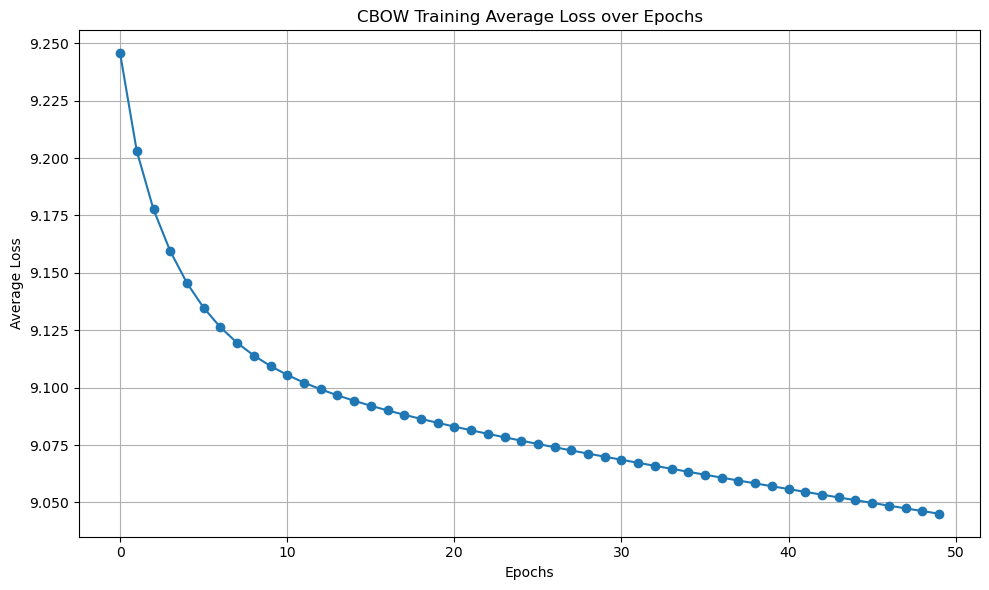

In [223]:
plt.figure(figsize=(10, 6))  # Adjusted the size for better clarity
plt.plot(epoch_losses_cbow, marker='o', linestyle='-')  # Adding a marker for each epoch
plt.title('CBOW Training Average Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.grid(True)  # Add a grid for better readability
plt.tight_layout()  # Adjust the layout for better aesthetics
plt.show()

4. Implement Skipgram:
- Create the architecture for Skipgram, which is essentially the inverse of CBOW.
- Generate training samples. For each word in the dataset, create pairs with n surrounding words.
- Train the model using a suitable optimizer and loss function.
- Extract word embeddings for the vocabulary.



In [260]:
# Generate training samples. For each word in the dataset, create pairs with n surrounding words.
def generate_skipgram_pairs(corpus, window_size, vocab_set):
    data = []

    for i, target_word in enumerate(corpus):  
        
        # Check if the current target word is in the vocabulary
        if target_word not in vocab_set:
            continue
        
        # Define the starting and ending positions for the window
        start_index = max(0, i - window_size)
        end_index = min(len(corpus), i + window_size + 1)

        # Iterate within the window range and collect context words
        for j in range(start_index, end_index):
            # Ensure we are not collecting the target word and the word collected is in the vocabulary
            if j != i and corpus[j] in vocab_set:
                # Directly append the context word and target word pair to the data list
                data.append((corpus[j], target_word))

    return data




In [261]:
# Check the generate function for skipgram
target_pairs = generate_skipgram_pairs(subsamped_lines[:30000], 2, top_freq_words)

# print head 10
# Use target to predict contex
for i, (context, target) in enumerate(target_pairs[:10]):
    print(f"Pair {i+1}:")
    print("Context:", context)
    print("Target:", target)
    print("----------------------")

Pair 1:
Context: originated
Target: anarchism
----------------------
Pair 2:
Context: working
Target: anarchism
----------------------
Pair 3:
Context: anarchism
Target: originated
----------------------
Pair 4:
Context: working
Target: originated
----------------------
Pair 5:
Context: anarchism
Target: working
----------------------
Pair 6:
Context: originated
Target: working
----------------------
Pair 7:
Context: organization
Target: used
----------------------
Pair 8:
Context: used
Target: organization
----------------------
Pair 9:
Context: positive
Target: organization
----------------------
Pair 10:
Context: label
Target: organization
----------------------


### Analysis `generate_skipgram_pairs`


- Since, for my logic the `generate_skipgram_pairs` should use target_word to predict our context, but we need to train our model to predict the target belong to contex, then we only need to get the one context not a list of contex.

e.g. “the quick brown fox”

The target_word is brown. 

we can get:

- brown, the
- brown, quick
- brown, fox

In [262]:
# Create the architecture for Skipgram
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.linear = nn.Linear(embed_dim, vocab_size)
        self.activation = nn.LogSoftmax(dim = 1)

    def forward(self, context_word):
        embeds = self.embeddings(context_word)
        out = self.linear(embeds)
        out = self.activation(out)
        return out
    
    

In [263]:
# Skipgram dataset
class SkipGramDataset(Dataset):
    def __init__(self, data, word2idx):
        self.data = data
        self.word2idx = word2idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
    
        context, target = self.data[idx]
        context_index = self.word2idx[context]
        target_index = self.word2idx[target]

        return torch.tensor(context_index, dtype=torch.long), torch.tensor(target_index, dtype=torch.long)
    
    
    


In [270]:
# Hyperparameters
embedding_dim = 100
learning_rate = 0.01
epochs = 50
window_size = 2
BATCH_SIZE = 1024

# Preparing data
vocab = set(top_freq_words)
word2idx = {word: i for i, word in enumerate(vocab)}
idx2word = {i: word for word, i in word2idx.items()}

# Preprocess data
training_data = generate_skipgram_pairs(subsamped_lines, window_size, vocab)
skipgram_dataset = SkipGramDataset(training_data, word2idx)
max_context_size = max([len(context) for context, _ in training_data])

skipgram_loader = DataLoader(skipgram_dataset, batch_size=BATCH_SIZE, shuffle=True)

# SkipGram Model, Optimizer, Loss Function
model_2 = SkipGram(len(vocab), embedding_dim).to(device)
optimizer_skipgram = torch.optim.SGD(model_2.parameters(), lr = learning_rate)
loss_fn_skipgram = nn.NLLLoss()

# List to store losses
epoch_losses_skipgram = []




In [271]:
# Training loop
for epoch in range(epochs):
    model_2.train()  # Set the model to training mode
    total_loss = 0.0
    total_samples = 0
    
    # Wrap skipgram_loader with tqdm for progress bar
    for context, target in tqdm(skipgram_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        # Convert data to appropriate device (CPU/GPU)
        context = context.to(device)
        target = target.to(device)
        
        optimizer_skipgram.zero_grad()  # Zero the gradients
        output = model_2(context)  # Forward pass
        loss = loss_fn_skipgram(output, target)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer_skipgram.step()  # Update the weights
        
        # Update total loss and total samples
        total_loss += loss.item() * len(target)
        total_samples += len(target)

    # Compute the average loss for this epoch
    epoch_loss_avg_skipgram = total_loss / total_samples
    epoch_losses_skipgram.append(epoch_loss_avg_skipgram)
    
    # Optionally print the loss for this epoch
    print(f"Epoch {epoch+1}/{epochs} - Avg Loss: {epoch_loss_avg_skipgram:.4f}")
    
    
    


Epoch 1/50: 100%|██████████| 5855/5855 [01:37<00:00, 59.90it/s]


Epoch 1/50 - Avg Loss: 9.3738


Epoch 2/50: 100%|██████████| 5855/5855 [01:47<00:00, 54.28it/s]


Epoch 2/50 - Avg Loss: 9.3648


Epoch 3/50: 100%|██████████| 5855/5855 [01:37<00:00, 60.03it/s]


Epoch 3/50 - Avg Loss: 9.3559


Epoch 4/50: 100%|██████████| 5855/5855 [01:36<00:00, 60.47it/s]


Epoch 4/50 - Avg Loss: 9.3472


Epoch 5/50: 100%|██████████| 5855/5855 [01:30<00:00, 64.58it/s]


Epoch 5/50 - Avg Loss: 9.3385


Epoch 6/50: 100%|██████████| 5855/5855 [01:45<00:00, 55.29it/s]


Epoch 6/50 - Avg Loss: 9.3300


Epoch 7/50: 100%|██████████| 5855/5855 [01:38<00:00, 59.18it/s]


Epoch 7/50 - Avg Loss: 9.3217


Epoch 8/50: 100%|██████████| 5855/5855 [01:28<00:00, 65.81it/s]


Epoch 8/50 - Avg Loss: 9.3134


Epoch 9/50: 100%|██████████| 5855/5855 [01:40<00:00, 58.16it/s]


Epoch 9/50 - Avg Loss: 9.3053


Epoch 10/50: 100%|██████████| 5855/5855 [01:44<00:00, 55.83it/s]


Epoch 10/50 - Avg Loss: 9.2974


Epoch 11/50: 100%|██████████| 5855/5855 [01:37<00:00, 60.05it/s]


Epoch 11/50 - Avg Loss: 9.2895


Epoch 12/50: 100%|██████████| 5855/5855 [01:49<00:00, 53.38it/s]


Epoch 12/50 - Avg Loss: 9.2819


Epoch 13/50: 100%|██████████| 5855/5855 [01:50<00:00, 52.85it/s]


Epoch 13/50 - Avg Loss: 9.2743


Epoch 14/50: 100%|██████████| 5855/5855 [01:50<00:00, 53.19it/s]


Epoch 14/50 - Avg Loss: 9.2670


Epoch 15/50: 100%|██████████| 5855/5855 [01:38<00:00, 59.21it/s]


Epoch 15/50 - Avg Loss: 9.2598


Epoch 16/50: 100%|██████████| 5855/5855 [01:29<00:00, 65.26it/s]


Epoch 16/50 - Avg Loss: 9.2527


Epoch 17/50: 100%|██████████| 5855/5855 [01:37<00:00, 60.35it/s]


Epoch 17/50 - Avg Loss: 9.2458


Epoch 18/50: 100%|██████████| 5855/5855 [01:41<00:00, 57.91it/s]


Epoch 18/50 - Avg Loss: 9.2390


Epoch 19/50: 100%|██████████| 5855/5855 [01:32<00:00, 63.17it/s]


Epoch 19/50 - Avg Loss: 9.2324


Epoch 20/50: 100%|██████████| 5855/5855 [01:34<00:00, 61.76it/s]


Epoch 20/50 - Avg Loss: 9.2259


Epoch 21/50: 100%|██████████| 5855/5855 [01:40<00:00, 58.28it/s]


Epoch 21/50 - Avg Loss: 9.2195


Epoch 22/50: 100%|██████████| 5855/5855 [01:31<00:00, 64.22it/s]


Epoch 22/50 - Avg Loss: 9.2133


Epoch 23/50: 100%|██████████| 5855/5855 [01:39<00:00, 59.10it/s]


Epoch 23/50 - Avg Loss: 9.2072


Epoch 24/50: 100%|██████████| 5855/5855 [01:31<00:00, 63.97it/s]


Epoch 24/50 - Avg Loss: 9.2013


Epoch 25/50: 100%|██████████| 5855/5855 [01:35<00:00, 61.25it/s]


Epoch 25/50 - Avg Loss: 9.1954


Epoch 26/50: 100%|██████████| 5855/5855 [01:33<00:00, 62.55it/s]


Epoch 26/50 - Avg Loss: 9.1897


Epoch 27/50: 100%|██████████| 5855/5855 [01:30<00:00, 64.69it/s]


Epoch 27/50 - Avg Loss: 9.1841


Epoch 28/50: 100%|██████████| 5855/5855 [01:36<00:00, 60.97it/s]


Epoch 28/50 - Avg Loss: 9.1786


Epoch 29/50: 100%|██████████| 5855/5855 [01:29<00:00, 65.35it/s]


Epoch 29/50 - Avg Loss: 9.1733


Epoch 30/50: 100%|██████████| 5855/5855 [01:35<00:00, 61.56it/s]


Epoch 30/50 - Avg Loss: 9.1680


Epoch 31/50: 100%|██████████| 5855/5855 [01:37<00:00, 59.89it/s]


Epoch 31/50 - Avg Loss: 9.1628


Epoch 32/50: 100%|██████████| 5855/5855 [01:31<00:00, 63.90it/s]


Epoch 32/50 - Avg Loss: 9.1577


Epoch 33/50: 100%|██████████| 5855/5855 [01:36<00:00, 60.73it/s]


Epoch 33/50 - Avg Loss: 9.1527


Epoch 34/50: 100%|██████████| 5855/5855 [01:37<00:00, 60.23it/s]


Epoch 34/50 - Avg Loss: 9.1479


Epoch 35/50: 100%|██████████| 5855/5855 [01:32<00:00, 63.28it/s]


Epoch 35/50 - Avg Loss: 9.1431


Epoch 36/50: 100%|██████████| 5855/5855 [01:33<00:00, 62.44it/s]


Epoch 36/50 - Avg Loss: 9.1383


Epoch 37/50: 100%|██████████| 5855/5855 [01:40<00:00, 58.20it/s]


Epoch 37/50 - Avg Loss: 9.1337


Epoch 38/50: 100%|██████████| 5855/5855 [01:29<00:00, 65.72it/s]


Epoch 38/50 - Avg Loss: 9.1292


Epoch 39/50: 100%|██████████| 5855/5855 [01:33<00:00, 62.93it/s]


Epoch 39/50 - Avg Loss: 9.1247


Epoch 40/50: 100%|██████████| 5855/5855 [01:39<00:00, 58.93it/s]


Epoch 40/50 - Avg Loss: 9.1203


Epoch 41/50: 100%|██████████| 5855/5855 [01:29<00:00, 65.44it/s]


Epoch 41/50 - Avg Loss: 9.1160


Epoch 42/50: 100%|██████████| 5855/5855 [01:33<00:00, 62.29it/s]


Epoch 42/50 - Avg Loss: 9.1117


Epoch 43/50: 100%|██████████| 5855/5855 [01:37<00:00, 59.89it/s]


Epoch 43/50 - Avg Loss: 9.1076


Epoch 44/50: 100%|██████████| 5855/5855 [01:28<00:00, 66.49it/s]


Epoch 44/50 - Avg Loss: 9.1035


Epoch 45/50: 100%|██████████| 5855/5855 [01:36<00:00, 60.64it/s]


Epoch 45/50 - Avg Loss: 9.0994


Epoch 46/50: 100%|██████████| 5855/5855 [01:30<00:00, 64.73it/s]


Epoch 46/50 - Avg Loss: 9.0955


Epoch 47/50: 100%|██████████| 5855/5855 [01:34<00:00, 62.25it/s]


Epoch 47/50 - Avg Loss: 9.0916


Epoch 48/50: 100%|██████████| 5855/5855 [01:37<00:00, 59.75it/s]


Epoch 48/50 - Avg Loss: 9.0877


Epoch 49/50: 100%|██████████| 5855/5855 [01:34<00:00, 61.84it/s]


Epoch 49/50 - Avg Loss: 9.0839


Epoch 50/50: 100%|██████████| 5855/5855 [01:37<00:00, 59.76it/s]

Epoch 50/50 - Avg Loss: 9.0802


### Check Model of skipgram

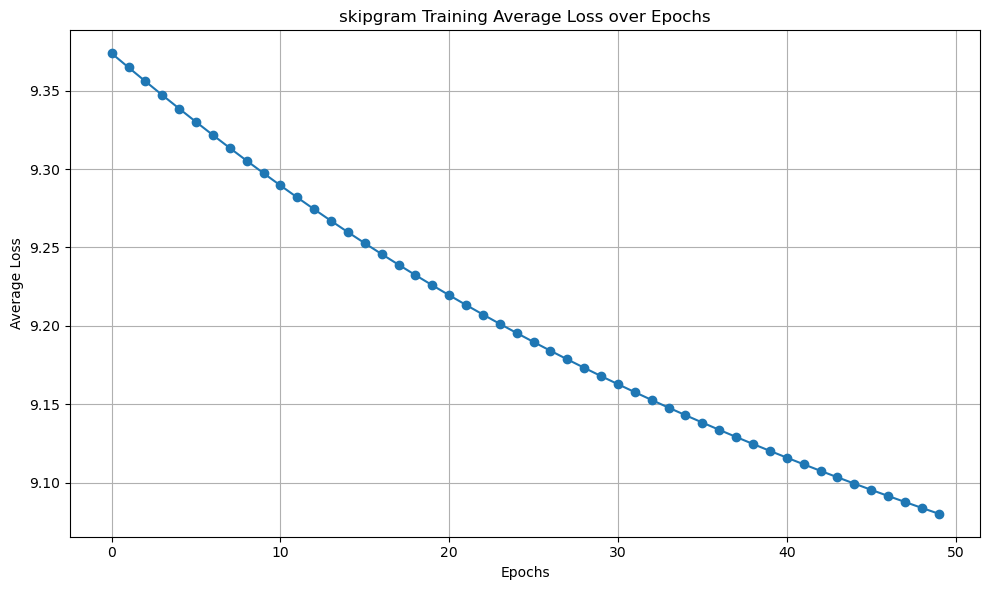

In [272]:
plt.figure(figsize=(10, 6))  # Adjusted the size for better clarity
plt.plot(epoch_losses_skipgram, marker='o', linestyle='-')  # Adding a marker for each epoch
plt.title('skipgram Training Average Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.grid(True)  # Add a grid for better readability
plt.tight_layout()  # Adjust the layout for better aesthetics
plt.show()

5. Evaluation:
- Implement a simple cosine similarity function to measure similarity between word pairs.
- Test the similarity of a few pairs of words (e.g., king & queen, man & woman, Paris & France).
- Visualize embeddings of some selected words using t-SNE or PCA.



### Use the consine similarity function to measure similarity:

- The formular is: similarity = cos $\theta$ = $\frac{A * B}{||A||*||B||}$

In [224]:
# do the consine similarity function

def cosine_similarity(a, b):
    dot_product = torch.dot(a, b)
    norm_a = torch.norm(a)
    norm_b = torch.norm(b)
    return dot_product / (norm_a * norm_b)


In [237]:
# word embedding
def get_word_embedding(word, model_type):
    index = word2idx[word]
    return model_type.embeddings(torch.tensor([index], device=device)).squeeze()

In [277]:
# Word case
word_case = ['king', 'queen', 'man', 'woman']

# check the word similary for cbow
embedding1_cbow, embedding2_cbow = get_word_embedding(word_case[0], model), get_word_embedding(word_case[1], model)
similarity1_cbow = cosine_similarity(embedding1_cbow, embedding2_cbow)
print(f"Use CBOW: Cosine similarity between {word_case[0]} and {word_case[1]}: {similarity1_cbow.item()}")
embedding3_cbow, embedding4_cbow = get_word_embedding(word_case[2], model), get_word_embedding(word_case[3], model)
similarity2_cbow = cosine_similarity(embedding3_cbow, embedding4_cbow)
print(f"Use CBOW: Cosine similarity between {word_case[2]} and {word_case[3]}: {similarity2_cbow.item()}")

# Check the word similary for skipgram
embedding1_skipgram, embedding2_skipgram = get_word_embedding(word_case[0], model_2), get_word_embedding(word_case[1], model_2)
similarity1_skipgram = cosine_similarity(embedding1_skipgram, embedding2_skipgram)
print(f"Use Skipgram: Cosine similarity between {word_case[0]} and {word_case[1]}: {similarity1_skipgram.item()}")
embedding3_skipgram, embedding4_skipgram = get_word_embedding(word_case[2], model_2), get_word_embedding(word_case[3], model_2)
similarity2_skipgram = cosine_similarity(embedding3_skipgram, embedding4_skipgram)
print(f"Use Skipgram: Cosine similarity between {word_case[2]} and {word_case[3]}: {similarity2_skipgram.item()}")



Use CBOW: Cosine similarity between king and queen: 0.10473997890949249
Use CBOW: Cosine similarity between man and woman: -0.09413544833660126
Use Skipgram: Cosine similarity between king and queen: 0.04361407086253166
Use Skipgram: Cosine similarity between man and woman: -0.05421862006187439


In [283]:
# Prepare the words to visualize
words_to_visualize = ['king', 'queen', 'man', 'woman', 'people', 'american',
                      'one',
                      'zero',
                      'nine',
                      'two',
                      'eight',
                      'five',
                      'three',
                      'four',
                      'six',
                      'seven',
                      'also',
                      'first',
                      'many',
                      'new',
                      'used',
                      'time',
                      'see',
                      'may',
                      'world'
                     ]

embeddings_cbow = [get_word_embedding(word, model) for word in words_to_visualize]
embeddings_skipgram = [get_word_embedding(word, model_2) for word in words_to_visualize]


In [281]:
# Dimensionality reduction of these embeddings using t-SNE

embeddings_cbow_np = np.array([embedding.cpu().detach().numpy() for embedding in embeddings_cbow])
embeddings_skipgram_np = np.array([embedding.cpu().detach().numpy() for embedding in embeddings_skipgram])

tsne = TSNE(n_components=2, perplexity=5)
reduced_embeddings_cbow = tsne.fit_transform(embeddings_cbow_np)
reduced_embeddings_skipgram = tsne.fit_transform(embeddings_skipgram_np)


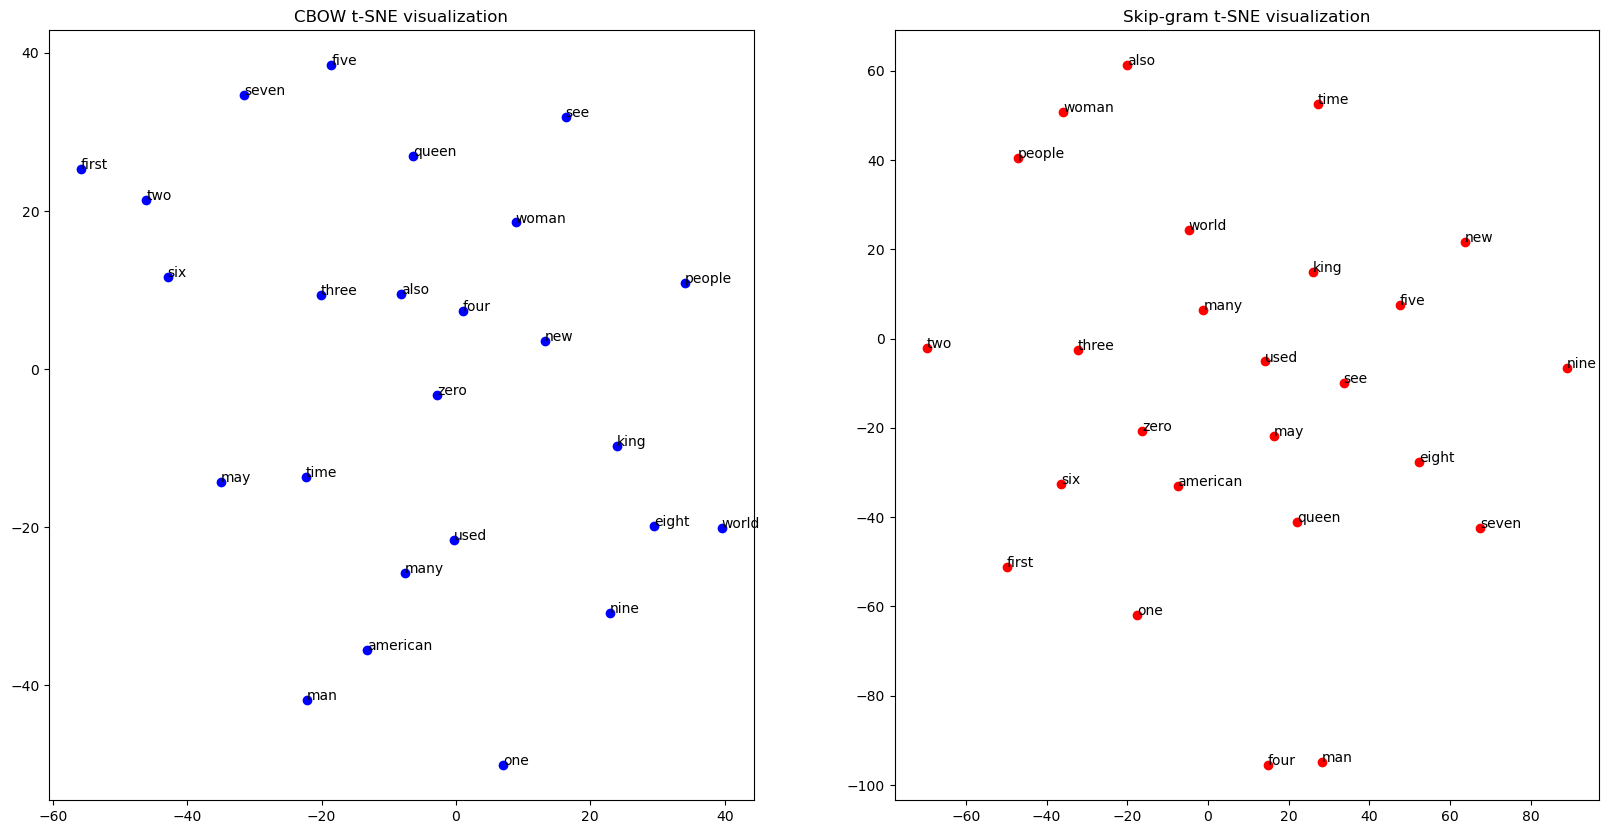

In [284]:
# Use visualization
plt.figure(figsize=(20, 10))

# CBOW t-SNE visualization
plt.subplot(1, 2, 1)
for i, word in enumerate(words_to_visualize):
    plt.scatter(reduced_embeddings_cbow[i, 0], reduced_embeddings_cbow[i, 1], color='blue')
    plt.annotate(word, (reduced_embeddings_cbow[i, 0], reduced_embeddings_cbow[i, 1]))
plt.title('CBOW t-SNE visualization')

# Skip-gram t-SNE visualization
plt.subplot(1, 2, 2)
for i, word in enumerate(words_to_visualize):
    plt.scatter(reduced_embeddings_skipgram[i, 0], reduced_embeddings_skipgram[i, 1], color='red')
    plt.annotate(word, (reduced_embeddings_skipgram[i, 0], reduced_embeddings_skipgram[i, 1]))
plt.title('Skip-gram t-SNE visualization')

plt.show()


6. Report:
- Provide a brief introduction to word embeddings, Skipgram, and CBOW.
- Discuss the architecture of the models.
- Describe the dataset and pre-processing steps.
- Present results from the evaluation step.
- Discuss challenges faced during implementation and potential improvements.
- Conclude with insights and potential applications of the implemented models.

### 1. Word Embeddings, Skipgram, and CBOW


- Word embedding is a technique where individual words are represented as real-valued vectors in a predefined lower-dimensional space. These vectors capture the semantics and relationships between words. CBOW (Continuous Bag of Words) and Skipgram are two popular models for generating these embeddings. In CBOW, context (a set of surrounding words) is used to predict the target word, whereas Skipgram does the opposite: it uses a target word to predict its context. For my implementation, I set the window size for context as 2.

### 2. Architecture of the Models

- In the CBOW model, a vocabulary of top frequency words (top_freq_words) was used. To deal with insufficient data length, I added a special token `NEU` as padding. This step was not required for the Skipgram model.

### 3. Dataset and Pre-processing

- The initial dataset was enormous, containing approximately 100 million records. To manage this, I performed subsampling and pre-processed the data by removing stopwords and non-alphabetic tokens. After cleaning, the vocabulary was further reduced to the top 10,000 frequency words, even though the cleaned vocabulary had around 10,888,361 words. I used a secondary subsampling technique that favored high-frequency words, which reduced my final corpus size to approximately 4,129,394 words.

### 4. Evaluation Results 

- The results from the similarity evaluation raised some concerns. 
- For example:
* CBOW: Cosine similarity between "king" and "queen": 0.1047
* CBOW: Cosine similarity between "man" and "woman": -0.0941
* Skipgram: Cosine similarity between "king" and "queen": 0.0436
* Skipgram: Cosine similarity between "man" and "woman": -0.0542
- These negative similarities for semantically related words like "man" and "woman" are counter-intuitive. The possible reasons could be insufficient training, lack of negative sampling, and the limited size of our vocabulary and corpus. This issue was also evident during visualization, where test words did not overlap significantly due to the limited vocabulary and corpus.
- In comparing the training loss of the Skipgram and CBOW models, there is a noticeable difference in their convergence rates. The Skipgram model exhibits a steeper slope in its average loss reduction, indicating a more consistent decline over epochs. In contrast, the CBOW model, while still showing a decrease, does so at a slower rate. One potential reason for this could be the granularity of the Skipgram model in predicting the context given a target word, allowing it to handle the vast amount of low-frequency words present in the corpus more effectively. Given that the CBOW model was trained with a vocabulary of top frequency words and utilized a special token NEU for padding, this might not fully capture the intricacies of the entire dataset, especially when dealing with words of lower frequency. As such, the inherent design of the Skipgram model appears to offer better learning efficacy in this context.

### 5. Challenges and Improvements

- One of the main challenges was handling the vast dataset. Apart from subsampling, I utilized a dataloader to manage the data in batches, which optimized GPU performance and significantly reduced training time. Another challenge was understanding the Skipgram model. Initially, I presumed it was just the reverse of CBOW, but later realized that while CBOW predicts a single word from a list (context), Skipgram predicts a single word as context from a target. For improvements, I suggest increasing the corpus size, adjusting hyperparameters for optimal performance, and expanding the vocabulary beyond the current 10,000 top frequency words to include more terms for prediction.

### 6. Insights and Applications

- Considering that Skipgram produces more refined word vectors and is suitable when the corpus contains many low-frequency words, it's preferable in such situations. On the other hand, when dealing with a majority of high-frequency words, CBOW might be more appropriate.